In [17]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.utils.data
import math
import numpy as np
import pandas as pd
import time
import pickle


np.random.seed(42)

In [18]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
def saveFiles(dict, savePath):
    df = pd.DataFrame.from_dict(dict, orient='index').transpose()
    df.to_csv(savePath, index=False)

# get trainInput, trainLabel, testInput, testLabel by window-based-data
def getDataTrainTest_csvTrue(pathStock,normalize,ss,winInput,numPredic):
    dfStock1 = pd.read_csv(pathStock, header=None).to_numpy()

    if normalize==True:
        dfStock2 = ss.fit_transform(dfStock1)
    else:
        dfStock2 = dfStock1

    # call function to  get trainInput, trainLabel, testInput, testLabel by window-based-data : train 816days & test 1day
    (trainInputL, trainLabelL, testInputL, testLabelL) = miniBatchOneDayLabel_1Label_5yr(dfStock2, winInput,numPredic)

    return(trainInputL, trainLabelL, testInputL, testLabelL,ss)

In [20]:
# get trainInput, trainLabel, testInput, testLabel by window-based-data : train 816days & test 1day
def miniBatchOneDayLabel_1Label_5yr(inputt,winInput,numPredic):

    # 1.get trainInput, trainLabel
    input2 = inputt.copy()
    input3 = input2.copy()
    indexFirstPrediction = inputt.shape[0]-30 #
    indexL = np.linspace(0, indexFirstPrediction - winInput + numPredic - 2, num=indexFirstPrediction - winInput + numPredic-1)
    dataTrainL=[]
    labelTrainL=[]
    for i in indexL:
        i = int(i)
        ii = input2[i:(i+ winInput),:]
        ll = input3[(i + winInput):(i+1 + winInput),:]
        dataTrainL.append(ii)
        labelTrainL.append(ll)
        print(-1)
    input2 = inputt.copy()
    input3 = input2.copy()
    indexL = np.linspace(1, indexFirstPrediction - winInput+numPredic-1, num=indexFirstPrediction - winInput + numPredic-1)

    # 2. get testInput, testLabel
    dataTestL=[]
    labelTestL=[]
    for i in indexL:
        i = int(i)
        ii = input2[i:(i+ winInput),:]
        ll = input3[(i + winInput):(i+1 + winInput),:]
        dataTestL.append(ii)
        labelTestL.append(ll)
    return(dataTrainL,labelTrainL,dataTestL, labelTestL)


In [21]:
class LSTM3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,dropout1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout1,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hs):
        out, hs = self.lstm(x, hs)
        out = self.fc(out)
        return out, hs

In [22]:
# get a pair of input & label
def getData2(data, label):
    y1List = data
    y2List = label
    y1L5 = [torch.Tensor(e) for i ,e in enumerate(y1List)]
    y2L5 = [torch.Tensor(e) for i, e in enumerate(y2List)]
    twoList = [(e1 ,e2) for i, e1 in enumerate(y1L5) for j, e2 in enumerate(y2L5) if i == j]
    return (y1L5, y2L5, twoList)

# call the function to get a pair of input & label
def getData(data, label, timeStep):
    (y1, y2, y12) = getData2(data, label)
    return (y12)

In [23]:
def trainLSTM3MSE(normalize, ss, model,
                  n_epochs, lrRnn, train_loader, test_loader, batchSizeTrain,
                  batchSizeTest, seq_lengthInput, seq_lengthLabel, inputSize, outputSize):

    criterion = nn.MSELoss() #meas squared loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lrRnn) #adam optimization for backpropagation

    # Training Run
    epochList = []
    lossListTrain = []
    lossListTest = []
    for epoch in range(1, n_epochs + 1): #start epoch
        start = time.time()
        epochList.append(epoch)
        lossSumTrain = 0
        hs = None
        outputTrainL=[]
        labelTrainL=[]
        outputTestL = []
        labelTestL = []
        for batch_idx, (input, label) in enumerate(train_loader): #train batch
            for batch_idx2, (inputTest, labelTest) in enumerate(test_loader): #test batch
                if batch_idx==batch_idx2: #run only when train-batch-index is same as test-batch-index
                    # change [b, inputSize,sequentialLength] to [b, sequentialLength, inputSize]
                    input = input.view(batchSizeTrain, seq_lengthInput,inputSize).float()
                    label = label.view(batchSizeTrain, seq_lengthLabel,outputSize).float()

                    outputTrain, h_state = model(input, hs)
                    outputTrain = outputTrain.float()
                    lossTrain = criterion(outputTrain, label) #apply our loss function with outputTrain and its label
                    optimizer.zero_grad()  # Clears existing gradients from previous epoch
                    lossTrain.backward()  # Does backpropagation and calculates gradients
                    optimizer.step()
                    lossSumTrain = lossSumTrain + lossTrain.detach().numpy()
                    outputTrainL.append(outputTrain) #list outpurTrain
                    labelTrainL.append(label)

                    ###################################################################
                    with torch.no_grad():
                        lossSumTest = 0
                        # change [b, inputSize,sequentialLength] to [b, sequentialLength, inputSize]
                        inputTest = inputTest.view(batchSizeTest, seq_lengthInput, inputSize).float()
                        labelTest = labelTest.view(batchSizeTest, seq_lengthLabel, outputSize).float()
                        # Forward pass only to get logits/output
                        outputTest, h_stateTest = model(inputTest, hs)
                        lossTest = criterion(outputTest, labelTest)  #apply our loss function with outputTest and its label
                        lossSumTest = lossSumTest + lossTest.detach().numpy() #sum test loss
                        outputTestL.append(outputTest) #list test output
                        labelTestL.append(labelTest)

        lossTrainAvgForOneEpoch1 = lossSumTrain / len(train_loader.dataset) #train loss for each epoch
        lossListTrain.append(lossTrainAvgForOneEpoch1)

        lossTestAvgForOneEpoch1 = lossSumTest / len(test_loader.dataset)  ##test loss for each epoch
        lossListTest.append(lossTestAvgForOneEpoch1)
        end = time.time()

        if epoch == 1:

            # 1. Train :
            outputTrainL2 = []
            for i in outputTrainL:
                i = i.detach().numpy()
                ii = i.reshape(i.shape[2], -1)
                outputTrainL2.append(ii) #list train output
            labelTrainL2 = []
            for i in labelTrainL:
                i = i.detach().numpy()
                ii = i.reshape(i.shape[2], -1)
                labelTrainL2.append(ii) #list train label
            outputTrainL3 = outputTrainL2.copy()
            trainL0 = outputTrainL3[0]  # (1)1st predicted 1228 timeSeries, [1212,1] (2)1st predicted 614 timeSeries, [614,1],
            if normalize == True:
                trainL1 = ss.inverse_transform(trainL0) #apply inverse transformation for standardization

            # 2. Test :
            outputTestL2 = []  # (1)644list w/ shape[614,1]
            for i in outputTestL:
                i = i.detach().numpy()
                ii = i.reshape(i.shape[2], -1)
                outputTestL2.append(ii)  #list test output
            labelTestL2 = []
            for i in labelTestL:
                i = i.detach().numpy()
                ii = i.reshape(i.shape[2], -1)
                labelTestL2.append(ii) #list test label
            outputTestL3 = outputTestL2.copy()
            testL0 = outputTestL3[0]  ## get scaler from a list

            if normalize == True:
                testL1 = ss.inverse_transform(testL0)

            print("Epoch :", epoch, '// One epoch time:', end - start, '// Train Error :', lossTrainAvgForOneEpoch1,
                  '// Test Error :', lossTestAvgForOneEpoch1)

        elif epoch > 1:
            ###############################################
            # find and save the minimum loss for each epoch
            ###############################################
            minLossTest = min(lossListTest[0:(epoch - 1)])
            if minLossTest > lossTestAvgForOneEpoch1:

                # 1. Train :
                outputTrainL2 = []
                for i in outputTrainL:
                    i = i.detach().numpy()
                    ii = i.reshape(i.shape[2], -1)
                    outputTrainL2.append(ii) #list train output
                labelTrainL2 = []
                for i in labelTrainL:
                    i = i.detach().numpy()
                    ii = i.reshape(i.shape[2], -1)
                    labelTrainL2.append(ii) #list train label
                outputTrainL3 = outputTrainL2.copy()
                trainL0 = outputTrainL3[0]  ### get scaler from a list
                if normalize == True:
                    trainL1 = ss.inverse_transform(trainL0)

                # 2. Test :
                outputTestL2 = []  # (1)644list w/ shape[614,1]
                for i in outputTestL:
                    i = i.detach().numpy()
                    ii = i.reshape(i.shape[2], -1)
                    outputTestL2.append(ii) #list test output
                labelTestL2 = []
                for i in labelTestL:
                    i = i.detach().numpy()
                    ii = i.reshape(i.shape[2], -1)
                    labelTestL2.append(ii) #list test label
                outputTestL3 = outputTestL2.copy()
                testL0 = outputTestL3[0]  # get scaler from a list

                if normalize == True:
                    testL1 = ss.inverse_transform(testL0) #apply inverse transformation for standardization

                print("Epoch :", epoch, '// One epoch time:', end - start, '// Train Error :', lossTrainAvgForOneEpoch1,
                      '// Test Error :', lossTestAvgForOneEpoch1)
            else:
                print("Epoch :", epoch, ": Current loss is bigger than previous")
                continue
    return (trainL1,testL1)

In [26]:
#prepare data and start run train and test day by day
def runDayByDay(trainInputL2, trainLabelL2, testInputL2, testLabelL2, time_step, shuffleTrain,batchSizeTrain,batchSizeTest,input_size,
                hidden_size, nLayer, output_size, dropout1,normalize, ss, method, stock, n_epochs, lrRnnAdam,seqLengthInput, seqLengthLabel):

    # get train data (trainInput,trainLabel) and test data (testInput,testLabel)
    train_xy = getData(trainInputL2, trainLabelL2, time_step)
    test_xy = getData(testInputL2, testLabelL2, time_step)

    # apply train data and test data into dataloader of pytorch
    if shuffleTrain == True:
        train_loader = torch.utils.data.DataLoader(dataset=train_xy,
                                                   batch_size=batchSizeTrain,
                                                   shuffle=True)
    elif shuffleTrain == False:
        train_loader = torch.utils.data.DataLoader(dataset=train_xy,
                                                   batch_size=batchSizeTrain,
                                                   shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_xy,
                                              batch_size=batchSizeTest,
                                              shuffle=False)

    model = LSTM3(input_size, hidden_size, nLayer, output_size, dropout1) #define our model

    ## call training and testing
    (predicTrain,predicTest) = trainLSTM3MSE(normalize, ss,model, n_epochs, lrRnnAdam,
                           train_loader, test_loader, batchSizeTrain, batchSizeTest,
                           seqLengthInput, seqLengthLabel, input_size, output_size)
    return(predicTrain,predicTest)

In [ ]:
def main():

    numPredic = 30 #We predict 30days
    winInput = 816  #input size for one batch
    winLabel=1 #label size for one batch
    comm = input('name of our commodity:') #name of our commodity
    method = 'seq'
    normalize = True #need to standardize
    shuffleTrain = False  #We do not shuffle
    lrRnnAdam = 0.01 #learning rate for optmization
    n_epochs = 2 #number of epoch
    dropout1 = 0 #did not use dropout regularization

    # get trainInput, trainLabel,testInput,testLabel for each commodity
    stock1 = f'./sample_data/{comm}.csv'
    ss1 = StandardScaler() #standardize
    (trainInputL, trainLabelL, testInputL, testLabelL,ss) = getDataTrainTest_csvTrue(stock1, normalize, ss1, winInput,numPredic)


    # set parameter values for LSTM
    time_step = winInput
    input_size = time_step
    seqLengthInput = 1
    seqLengthLabel = 1
    hidden_size = 512  #number of hidden node
    nLayer = 1 #number of LSTM
    output_size = 1

    batchSizeTrain = 1
    batchSizeTest = 1

    # start training and testing from each test day
    outWinL = []
    for j in range(len(testInputL)-1):
        trainInputL2 = [trainInputL[j]]
        trainLabelL2 = [trainLabelL[j]]
        testInputL2 = [testInputL[j]]
        testLabelL2 = [testLabelL[j]]

        # The predicted test label of previous day becomes train imput of next day
        (trainInputL[j+1][815],testInputL[j+1][815]) = runDayByDay(trainInputL2, trainLabelL2, testInputL2, testLabelL2, time_step, shuffleTrain,batchSizeTrain,batchSizeTest,input_size,
                hidden_size, nLayer, output_size, dropout1,normalize, ss, method, comm, n_epochs, lrRnnAdam,seqLengthInput, seqLengthLabel)
        outWinL.append(testInputL[j+1][815])   #save the prediction of each test day

    # predict last day, which is 30th day
    trainInputL2 = [trainInputL[29]]
    trainLabelL2 = [trainLabelL[29]]
    testInputL2 = [testInputL[29]]
    testLabelL2 = [testLabelL[29]]
    (predicFirstDayTrain, predicFirstDayTest) = runDayByDay(trainInputL2, trainLabelL2, testInputL2,
                                                                      testLabelL2, time_step,
                                                                      shuffleTrain, batchSizeTrain, batchSizeTest,
                                                                      input_size,
                                                                      hidden_size, nLayer, output_size, dropout1,
                                                                      normalize, ss, method, comm,
                                                                      n_epochs, lrRnnAdam, seqLengthInput,
                                                                      seqLengthLabel)

    predicFirstDayTest2 = predicFirstDayTest.reshape(predicFirstDayTest.shape[0],)
    outWinL2 =  outWinL + [predicFirstDayTest2]
    outWin3 = np.array(outWinL2)
    outWin4 = outWin3.reshape(-1, outWin3.shape[1])

    # save the predicted 30 day
    np.savetxt(
        './predictedTest_crypto{}_mimicKalmanModified_{}winInput{}winLabel_{}epoch.csv'.format(
            comm, winInput, winLabel, n_epochs), outWin4, delimiter=",")


if __name__ == "__main__":
    # execute only if run as a script
    main()




스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch : 2 // One epoch time: 0.08742237091064453 // Train Error : 13.940241813659668 // Test Error : 2.5416672229766846
Epoch : 1 // One epoch time: 0.09215974807739258 // Train Error : 2.261718273162842 // Test Error : 17.055097579956055
Epoch : 2 // One epoch time: 0.09430813789367676 // Train Error : 16.600322723388672 // Test Error : 3.962170362472534
Epoch : 1 // One epoch time: 0.09357285499572754 // Train Error : 1.9775290489196777 // Test Error : 16.053544998168945
Epoch : 2 // One epoch time: 0.07803726196289062 // Train Error : 16.657556533813477 // Test Error : 3.5187714099884033
Epoch : 1 // One epoch time: 0.0918130874633789 // Train Error : 2.347979784011841 // Test Error : 12.126880645751953
Epoch : 2 // One epoch time: 0.08082866668701172 // Train Error : 12.51921272277832 // Test Error : 2.469717025756836
Epoch : 1 // One epoch time: 0.09046030044555664 // Train Error : 2.4390993118286133 // Test Error : 14.260661125183105
Epoch : 2 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

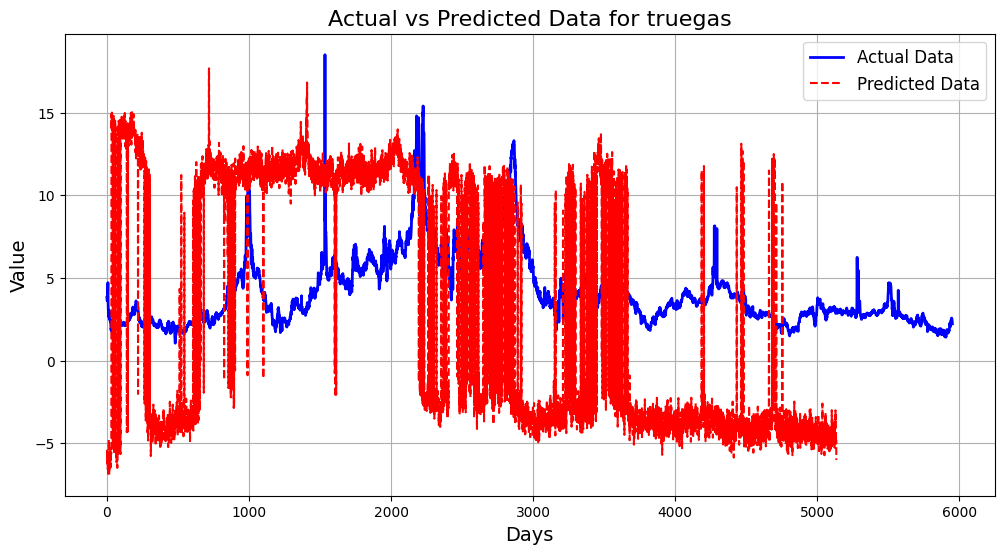

In [31]:
def visualize_predictions(comm, actual_file, predicted_file):

    #실제 데이터와 예측 데이터를 시각화합니다.
    #:param comm: 상품 이름
    #:param actual_file: 실제 데이터 파일 경로
    #:param predicted_file: 예측 데이터 파일 경로

    # 실제 데이터 로드
    actual_data = pd.read_csv(actual_file, header=None).values.flatten()

    # 예측 데이터 로드
    predicted_data = pd.read_csv(predicted_file, header=None).values.flatten()

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(actual_data, label="Actual Data", color="blue", linewidth=2)
    plt.plot(predicted_data, label="Predicted Data", color="red", linestyle="--")

    plt.title(f"Actual vs Predicted Data for {comm}", fontsize=16)
    plt.xlabel("Days", fontsize=14)
    plt.ylabel("Value", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    comm = comm

    actual_file = f"./sample_data/{comm}.csv"  # 실제 데이터 파일 경로
    predicted_file = f"./predictedTest_crypto{comm}_mimicKalmanModified_{816}winInput{1}winLabel_{2}epoch.csv"  # 예측 데이터 파일 경로

    # 시각화 함수 호출
    visualize_predictions(comm, actual_file, predicted_file)
